## **Predicting volatility**

In [21]:
%load_ext autoreload
%load_ext sql
%autoreload 2
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys 
import os
import sqlite3
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
project_root = os.path.abspath(os.path.join(".."))  
if project_root not in sys.path:
    sys.path.append(project_root)
from data import AlphaVantageAPI , SQLRepository
from utils.config import settings   
from models.model import GarchModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [22]:
#connect to the database 
connection = sqlite3.connect(settings.db_name , check_same_thread=False )
repo= SQLRepository(connection=connection)

#read and get data
ambuja_model =GarchModel(ticker="AMBUJACEM.BSE",repo=repo,use_new_data=False )
y_ambuja =ambuja_model.wrangle_data(n_observations=2000)

suzlon_model =GarchModel(ticker="SUZLON.BSE",repo=repo,use_new_data=False )
y_suzlon=suzlon_model.wrangle_data(n_observations=2000)

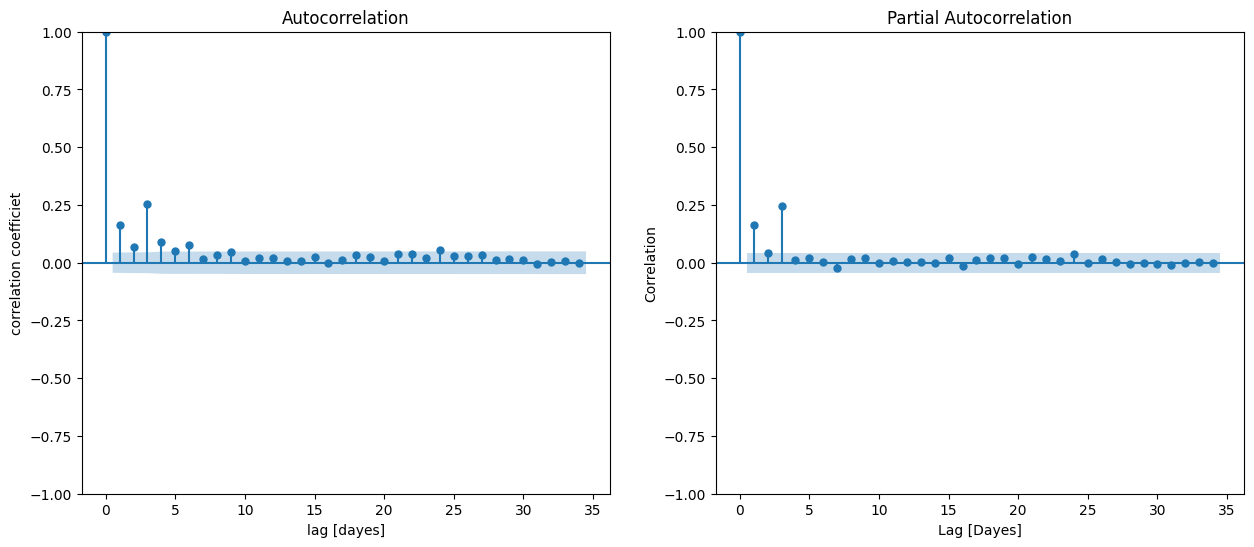

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_ambuja**2 , ax=ax[0])
# Add axis labels
ax[0].set_xlabel("lag [dayes]")
ax[0].set_ylabel("correlation coefficiet")

# Create PACF of squared returns
plot_pacf(y_ambuja**2, ax=ax[1])

# Add axis labels
ax[1].set_xlabel("Lag [Dayes]")
ax[1].set_ylabel("Correlation");

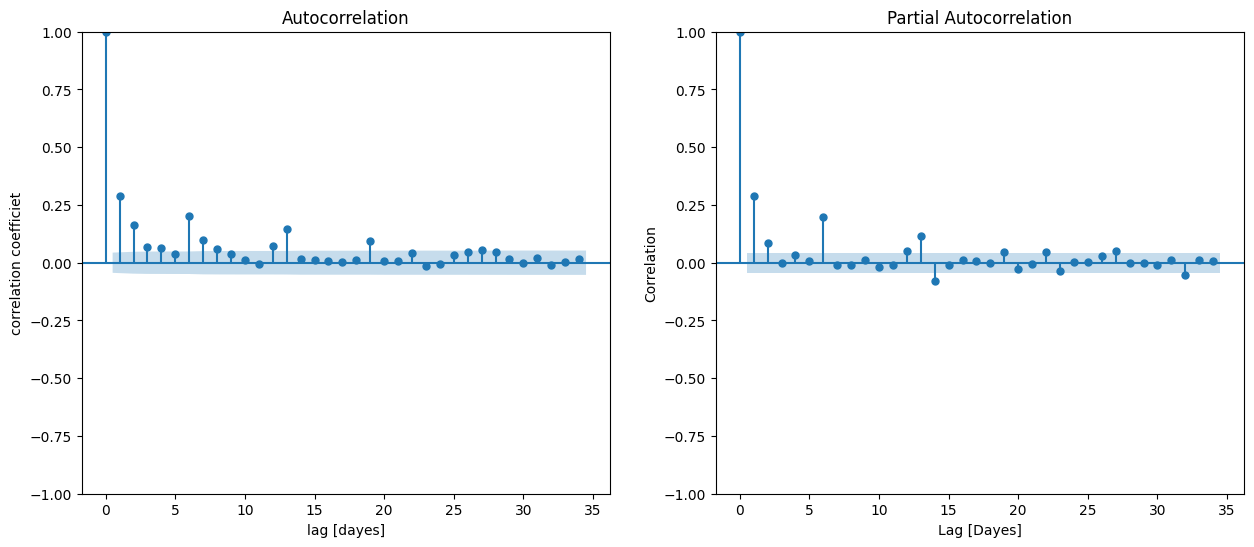

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_suzlon**2 , ax=ax[0])
# Add axis labels
ax[0].set_xlabel("lag [dayes]")
ax[0].set_ylabel("correlation coefficiet")

# Create PACF of squared returns
plot_pacf(y_suzlon**2, ax=ax[1])

# Add axis labels
ax[1].set_xlabel("Lag [Dayes]")
ax[1].set_ylabel("Correlation");

now from the previous acf and pcf plots we found that the current value of the return is debends on lag 1 or 2 days 

Training and evaluating the model

In [25]:
y_suzlon.tail(1)

date
2025-12-05    1.769912
Name: return, dtype: float64

forcast the upcomming 10 days for suzlon stocks

In [26]:
suzlon_model.fit(1,1)
suzlon_model.predict_volatility(10)

{'2025-12-08T00:00:00': 1.0511246772535368,
 '2025-12-09T00:00:00': 1.0536170509665084,
 '2025-12-10T00:00:00': 1.055761171072358,
 '2025-12-11T00:00:00': 1.0576274290112582,
 '2025-12-12T00:00:00': 1.059267196295253,
 '2025-12-15T00:00:00': 1.0607191205420863,
 '2025-12-16T00:00:00': 1.0620130115315731,
 '2025-12-17T00:00:00': 1.0631723466003742,
 '2025-12-18T00:00:00': 1.0642159455205598,
 '2025-12-19T00:00:00': 1.0651591250108845}

In [27]:
y_ambuja.tail(1)

date
2025-12-05   -0.540289
Name: return, dtype: float64

In [28]:
ambuja_model.fit(1,1)
ambuja_model.predict_volatility(10)

{'2025-12-08T00:00:00': 1.0197498262652895,
 '2025-12-09T00:00:00': 1.022493019729369,
 '2025-12-10T00:00:00': 1.0246980050200525,
 '2025-12-11T00:00:00': 1.0265025801312742,
 '2025-12-12T00:00:00': 1.0279996052273541,
 '2025-12-15T00:00:00': 1.0292546002995713,
 '2025-12-16T00:00:00': 1.0303154798697778,
 '2025-12-17T00:00:00': 1.0312182999439046,
 '2025-12-18T00:00:00': 1.0319908316414386,
 '2025-12-19T00:00:00': 1.0326548799206452}

saving both models

In [29]:
ambuja_model.dump()
suzlon_model.dump()


'../saved_models\\2025-12-08T19-04-08.198080_SUZLON.BSE.pkl'

In [36]:
# loading the models again 
ambuja=GarchModel(ticker="AMBUJACEM.BSE",repo=repo ,use_new_data=False)
ambuja_model=ambuja.load()

In [37]:
ambuja_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4140.91
Distribution:                  Normal   AIC:                           8289.82
Method:            Maximum Likelihood   BIC:                           8312.22
                                        No. Observations:                 2000
Date:                Mon, Dec 08 2025   Df Residuals:                     1999
Time:                        19:04:08   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0461  4.168e-02      1.106      0.269 [-3.561e-02,  0.128]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5034      0.233      2.156  3.109e-02 [4.574e-02,  0.961]
alpha[1]       0.1530  5.201e-02      2.941  3.269e-03 [5.103e-02,  0.255]
beta[1]        0.7303  8.968e-02      8.143  3.866e-16   [  0.554,  0.906]
==========================================================================

Covariance estimator: robust
"""

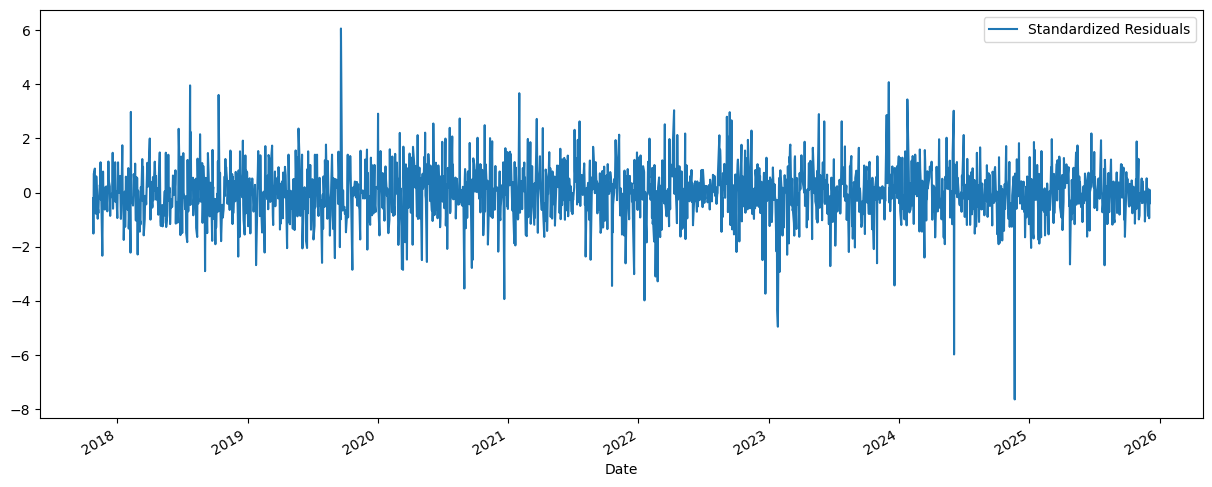

In [38]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
ambuja_model.std_resid.plot(ax=ax ,label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();


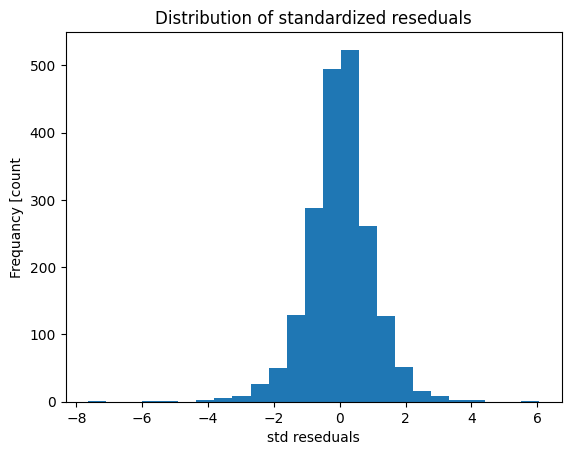

In [39]:
# Create histogram of standardized residuals, 25 bins
plt.hist(ambuja_model.std_resid ,bins=25)

# Add axis labels

plt.xlabel("std reseduals")
plt.ylabel("Frequancy [count")

# Add title
plt.title("Distribution of standardized reseduals");


now final step lets predict the volatility for the upcomming 30 days for ambujacem company 

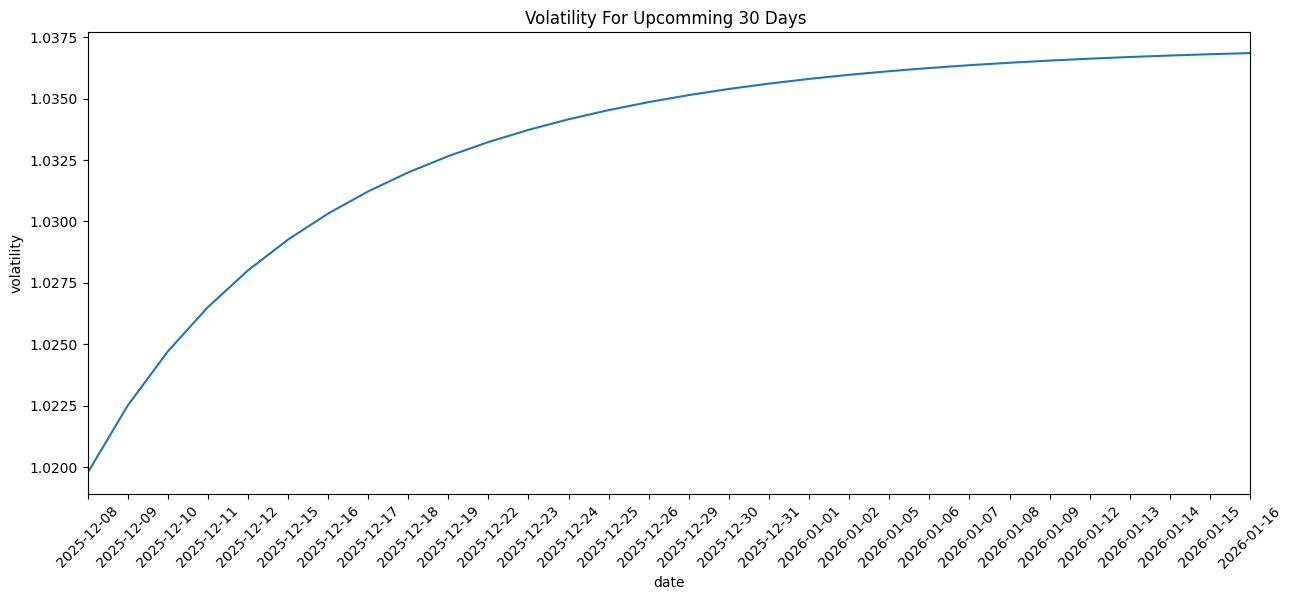

In [50]:
vol = pd.Series(ambuja.predict_volatility(30))

# Convert index to datetime (VERY IMPORTANT)
vol.index = pd.to_datetime(vol.index)

fig, ax = plt.subplots(figsize=(15,6))
vol.plot(ax=ax)

# Set ticks = all forecast dates
ax.set_xticks(vol.index)
ax.set_xticklabels(vol.index.strftime("%Y-%m-%d"), rotation=45)

#labels 
ax.set_xlabel("date")
ax.set_ylabel("volatility")

ax.set_title("Volatility For Upcomming 30 Days ")

plt.show()
